In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math
import pywt

# **1:MMSE estimation for Laplacian source**


$$Y = X + Z$$
$$X \sim Laplacian(0,\sigma_{X}), \quad \sigma_{X} = 1 $$
$$Z \sim Gaussian(0,\sigma_{Z}), \quad \sigma_{Z}^{2} = 0.1  $$



Gaussian PDF (Noise):
$$P_{z}(z) = \frac{1}{\sigma_{z}\sqrt{2\pi}} e^{-\frac{z^{2}}{2\sigma_{z}^{2}}}
$$

Laplacian PDF (Image):
$$
P_{x}(x) = \frac{1}{2\sigma_{x}} e^{-\frac{|x|^{\alpha}}{\sigma_{x}}}
$$


### Helper Functions

In [ ]:
def gaussian_pdf(x, mu = 0, sigma_sq = 0.1):
    return (1 / math.sqrt(2 * math.pi * sigma_sq)) * math.exp(-0.5 * ((x - mu) ** 2) / sigma_sq)

def P(x, alpha=1):
    return 0.5 * math.exp(-(abs(x)**alpha))

def condP(x,y):
  return gaussian_pdf(y-x)

MMSE Estimate:
$$\hat{X}(y)\quad : \quad\arg\min_{\hat{x}(y)} \mathbb{E}[(x - \hat{x}(y))^2]$$

$$\hat{X}(y)\quad = \quad \mathbb{E}[X|Y]\quad = \quad\int x \cdot P_{x|y}(x|y)\, dx \quad = \quad \int \frac{
    x \cdot P_x(x) \cdot P_{y|x}(y|x) \, dx
}{
   P_y
}$$

$$ \hat{X}(y)\quad = \quad
\frac{
    \int x \cdot P_x(x) \cdot P_{y|x}(y|x) \, dx
}{
    \int P_x(x) \cdot P_{y|x}(y|x) \, dx
}
$$

$$ \hat{X}(y)\quad = \quad
\frac{
    \int x \cdot P_x(x) \cdot P_z(y - x) \, dx
}{
    \int P_x(x) \cdot P_z(y - x) \, dx
}
$$

Solved by numerical integration technique

In [ ]:
def integrate_function(func, a, b, num_points=100000):
    x_values = np.linspace(a, b, num_points)
    y_values = np.array([func(i) for i in x_values])
    dx = (b - a) / (num_points - 1)
    integral_sum = sum(dx * y_values[i] for i in range(len(y_values)))
    return integral_sum

### Main Function

In [ ]:
def integral_num(y, alpha):
    integrand = lambda x: x * P(x, alpha) * condP(x, y)
    integral_value = integrate_function(integrand, -1000, 1000)
    return integral_value

def integral_den(y, alpha):
    integrand = lambda x: P(x, alpha) * condP(x, y)
    integral_value = integrate_function(integrand, -1000, 1000)
    return integral_value

def integral(y, alpha):
    result = integral_num(y, alpha)/integral_den(y, alpha)
    return result

### Plots

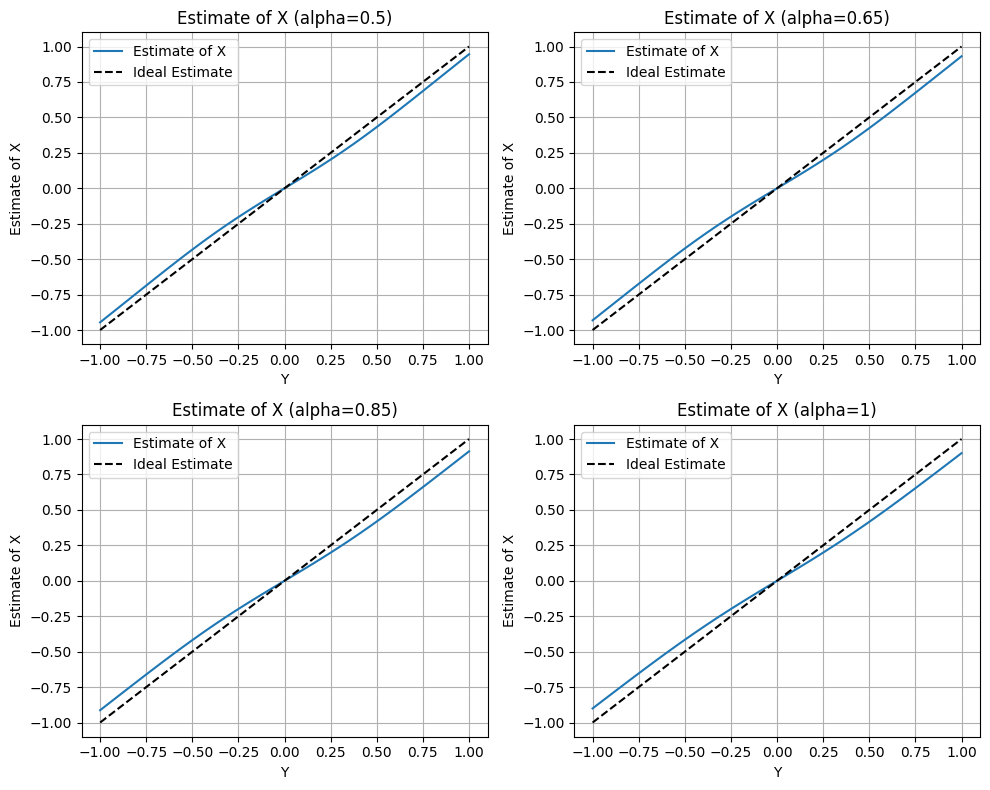

In [ ]:
alpha_values = [0.5, 0.65, 0.85, 1]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
for i, alpha in enumerate(alpha_values):
    y = np.linspace(-1, 1, 100)
    X_hat = np.array([integral(num, alpha) for num in y])

    axs[i].plot(y, X_hat, label='Estimate of X')
    axs[i].plot(y, y, 'k--', label='Ideal Estimate')
    axs[i].set_xlabel('Y')
    axs[i].set_ylabel('Estimate of X')
    axs[i].set_title(f'Estimate of X (alpha={alpha})')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# **2:Image Denoising**

##  2.1 Low Pass Gaussian Filter

### Preprocessing

In [ ]:
image  = cv2.imread('/content/lighthouse2.bmp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
def add_gaussian_noise(image, mean=0, sigma=10):
    row, col = image.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

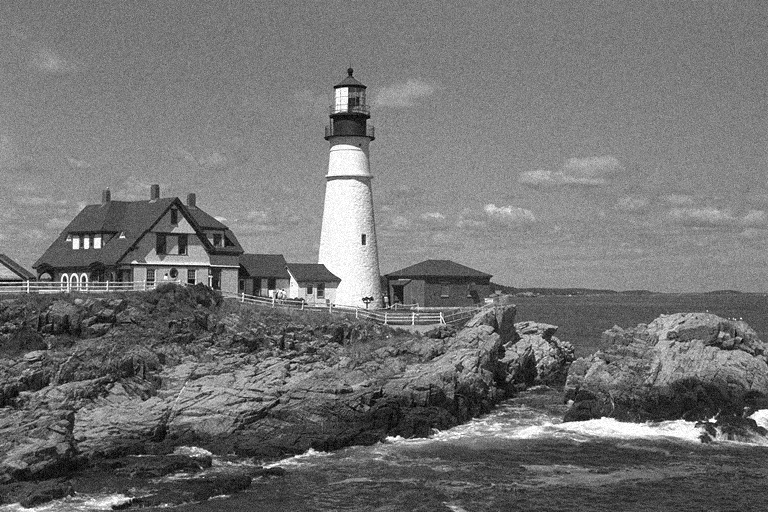

In [ ]:
noisy_image = add_gaussian_noise(image)
cv2_imshow(noisy_image)

In [ ]:
SIGMA_Z = 10

### Gaussian Kernels

$$ Y = X + Z $$
$$ \mu_{Y} = \mu_{X} + \mu_{Z} $$
$$ X = \mu_{x} + X_{1} $$
Low Pass Gaussian estimate of X:
$$ \mu_{z} \approx 0, \quad \therefore \hat{X}(y) \approx \mu_{y} $$
where:
$$\mu_{y} = Y(i,j)*W(k,l) $$

In [ ]:
def apply_gaussian_filter(image, kernel_size, sigma):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def find_best_filter(original_image , noisy_image, kernels, sigmas):
    best_mse = float('inf')
    best_kernel_size = None
    best_sigma = None
    best_filtered_image = None
    mse_values = []

    for kernel in kernels:
        mse_row = []
        for sigma in sigmas:

            filtered_image = apply_gaussian_filter(noisy_image, kernel, sigma)
            mse = np.mean((original_image - filtered_image) ** 2)
            mse_row.append(mse)

            if mse < best_mse:
                best_mse = mse
                best_kernel_size = kernel
                best_sigma = sigma
                best_filtered_image = filtered_image
        mse_values.append(mse_row)

    return best_kernel_size, best_sigma, best_mse, best_filtered_image,mse_values

### Results

In [ ]:
kernels = [3, 7, 11]
sigmas = [0.1, 1, 2, 4, 8]


best_kernel_size, best_sigma, best_mse, best_filtered_image, mse_values  = find_best_filter(image, noisy_image, kernels, sigmas)


print("Best kernel size:", best_kernel_size)
print("Best sigma:", best_sigma)
print("Best MSE:", best_mse)



Best kernel size: 3
Best sigma: 1
Best MSE: 36.82593027750651


Best Denoised Image

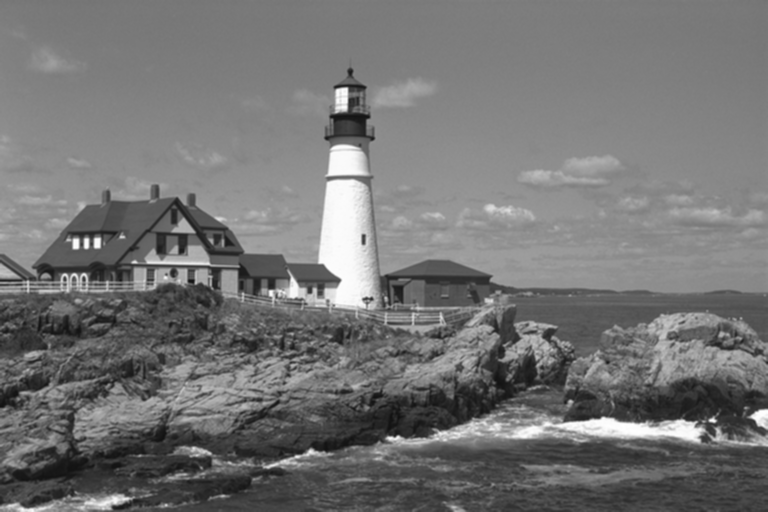

In [ ]:
best_filtered_image = apply_gaussian_filter(image, best_kernel_size, best_sigma)
cv2_imshow(best_filtered_image)

### Plots

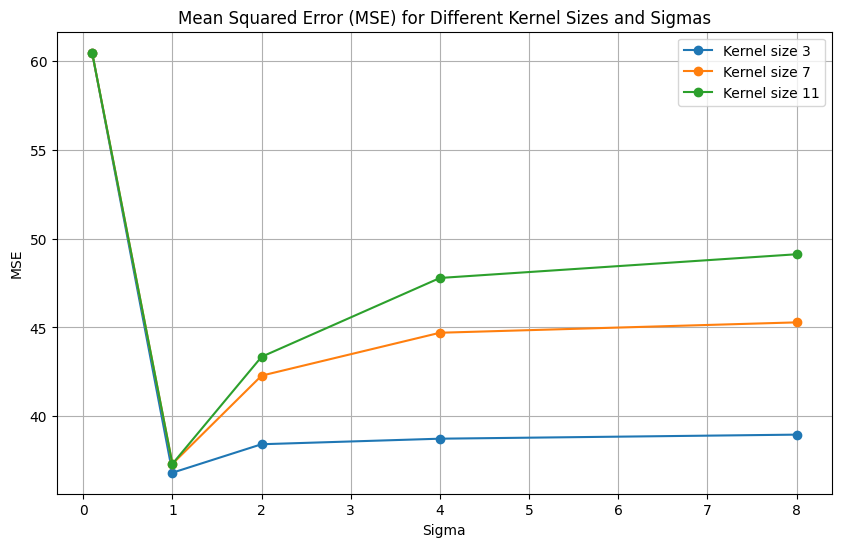

In [ ]:
plt.figure(figsize=(10, 6))
for i, kernel_size in enumerate(kernels):
    plt.plot(sigmas, mse_values[i], label=f'Kernel size {kernel_size}',marker='o')

plt.title('Mean Squared Error (MSE) for Different Kernel Sizes and Sigmas')
plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## 2.2 Adaptive MMSE

### Preprocessing

In [ ]:
SIGMA_Z = 10

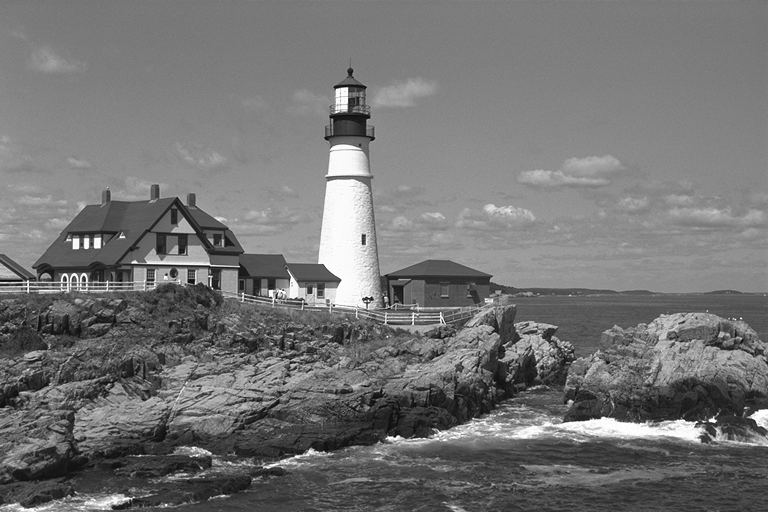

In [ ]:
image  = cv2.imread('/content/lighthouse2.bmp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)

In [ ]:
def add_gaussian_noise(image, mean=0, sigma=10):
    row, col = image.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

$$ Y = X + Z$$
$$Y \sim Gaussian(0,\sigma_{Y}) $$
$$X \sim Gaussian(0,\sigma_{X}) $$
$$Z \sim Gaussian(0,\sigma_{Z}), \quad \sigma_{Z} = 10  $$

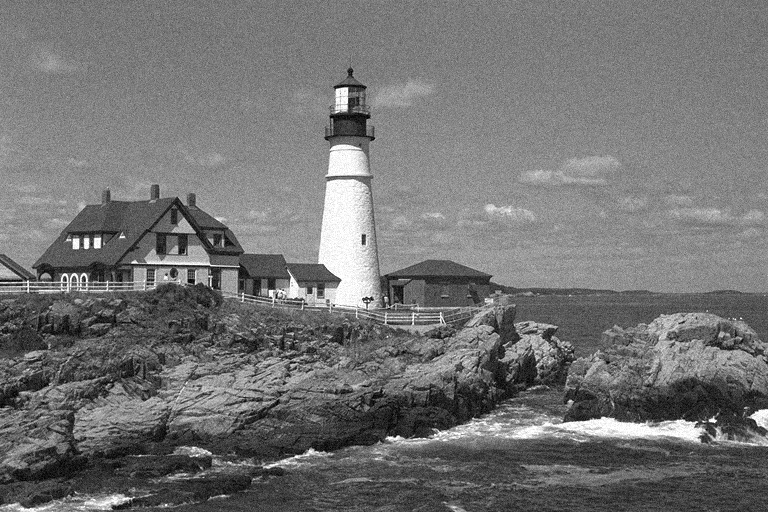

In [ ]:
noisy_image = add_gaussian_noise(image)
cv2_imshow(noisy_image)

### Helper functions

Gaussian Kernel/Filter and Convolution

2D Gaussian Kernel
$$G(m, n) = \frac{1}{2\pi \sigma^2} \exp\left(-\frac{m^2 + n^2}{2 \sigma^2}\right)$$


Convolution of image with Gaussian Kernel is the low pass component of Image
$$\mu_{x} = X(i,j)*G(m,n)$$

In [ ]:
def create_gaussian_kernel(sigma_w, kernel_size):
    kernel_range = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    kernel_1d = np.exp(-(kernel_range ** 2) / (2 * sigma_w ** 2))
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    kernel_2d /= np.sum(kernel_2d)
    return kernel_2d

def convolve(image, kernel):
    kernel_size = kernel.shape[0]
    pad_amount = kernel_size // 2
    padded_image = np.pad(image, pad_amount, mode='constant')
    height, width = image.shape
    convolved_image = np.zeros_like(image, dtype=np.float32)
    for i in range(height):
        for j in range(width):
            convolved_image[i, j] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size] * kernel)
    return convolved_image

Computation of lowpass and highpass components

$$ \mu_{x}: Low\ pass\ component $$
$$X_{1} = X - \mu_{x} : High\ pass\ component $$


In [ ]:
def compute_low_pass_image(image, sigma_w, kernel_size = 5):
  lowpass = apply_gaussian_filter(image, kernel_size, sigma_w)
  return lowpass

def compute_high_pass_image(image, sigma_w=1, kernel_size=5):
    lowpass = compute_low_pass_image(image, sigma_w, kernel_size)
    highpass = image.astype(np.float32) - lowpass
    return highpass

In [ ]:
def compute_image_variance(image):
    mean_value = np.mean(image)
    squared_diff = (image - mean_value) ** 2
    variance = np.mean(squared_diff)
    return variance

def compute_highpass_noise_variance(kernel, sigma_z = SIGMA_Z):
    kernel_size = kernel.shape[0]
    idx = int((kernel_size - 1 )/ 2)
    temp1 = (1-kernel[idx][idx])**2
    temp2 = np.sum(kernel**2) - (kernel[idx][idx]**2)
    sigma_z1 = ((temp1**2)+(temp2**2))*(sigma_z**2)
    return sigma_z1

$$\mu{x} \approx \mu{y}$$
$$\hat{X_{1}}(Y_1) \approx \frac{\sigma_{x}^2}{\sigma_{x}^2 + \sigma_{z}^2}\cdot Y_1 $$
For MMSE estimate:
$$\hat{X} = \mu{y} + \hat{X_{1}}(Y_1) $$

In [ ]:
def mmse_estimate(image, sigma_w, kernel_size, sigma_z = SIGMA_Z):

  Y = image
  mu_Y = compute_low_pass_image(Y, sigma_w, kernel_size)
  Y1 = compute_high_pass_image(Y, sigma_w, kernel_size)
  sigma2_y1 = compute_image_variance(Y1)

  kernel = create_gaussian_kernel(sigma_w, kernel_size)
  sigma2_z1 = compute_highpass_noise_variance(kernel, sigma_z = SIGMA_Z)

  sigma2_x1 = sigma2_y1 - sigma2_z1
  X1_hat  = ((sigma2_x1)/(sigma2_x1 + sigma2_z1 + 0.00001))*Y1
  X_hat = mu_Y + X1_hat

  return X_hat

In [ ]:
a = mmse_estimate(noisy_image,1, 3 )

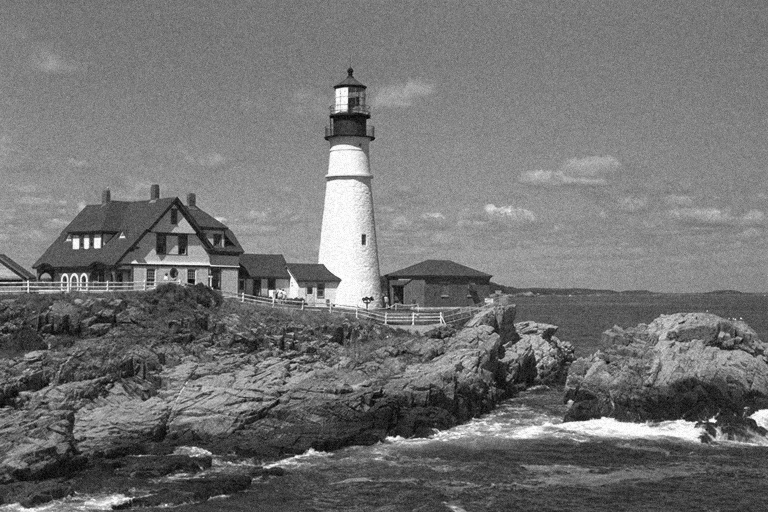

In [ ]:
cv2_imshow(a)

In [ ]:
mse = np.mean((a-image)**2)
mse

67.25119

In [ ]:
def adaptive_mmse_denoising(image, sigma_w, kernel_size, patch_size=(32, 32), overlap=16, sigma_z=SIGMA_Z):

    height, width = image.shape
    denoised_image = np.zeros_like(image, dtype=np.float32)
    count_image = np.zeros_like(image, dtype=np.float32)

    for y in range(0, height - patch_size[0] + 1, patch_size[0] - overlap):
        for x in range(0, width - patch_size[1] + 1, patch_size[1] - overlap):

            noisy_patch = image[y:y+patch_size[0], x:x+patch_size[1]]
            denoised_patch = mmse_estimate(noisy_patch, sigma_w, kernel_size, sigma_z)
            denoised_image[y:y+patch_size[0], x:x+patch_size[1]] += denoised_patch

            for j in range(y,y+patch_size[0]):
                for i in range(x,x+patch_size[1]):
                  count_image[j,i] += 1

    denoised_image /= count_image
    return denoised_image

In [ ]:
def find_best_filter_ordinary(original_image , noisy_image, kernels, sigmas):
    best_mse = float('inf')
    best_kernel_size = None
    best_sigma = None
    best_filtered_image = None
    mse_values = []

    for kernel in kernels:
        mse_row = []
        for sigma in sigmas:

            filtered_image = mmse_estimate(noisy_image, sigma, kernel)
            mse = np.mean((original_image - filtered_image) ** 2)
            mse_row.append(mse)

            if mse < best_mse:
                best_mse = mse
                best_kernel_size = kernel
                best_sigma = sigma
                best_filtered_image = filtered_image
        mse_values.append(mse_row)

    return best_kernel_size, best_sigma, best_mse, best_filtered_image,mse_values

In [ ]:
def find_best_filter_adaptive(original_image , noisy_image, kernels, sigmas):
    best_mse = float('inf')
    best_kernel_size = None
    best_sigma = None
    best_filtered_image = None
    mse_values = []

    for kernel in kernels:
        mse_row = []
        for sigma in sigmas:

            filtered_image = adaptive_mmse_denoising(noisy_image, sigma, kernel)
            mse = np.mean((original_image - filtered_image) ** 2)
            mse_row.append(mse)

            if mse < best_mse:
                best_mse = mse
                best_kernel_size = kernel
                best_sigma = sigma
                best_filtered_image = filtered_image
        mse_values.append(mse_row)

    return best_kernel_size, best_sigma, best_mse, best_filtered_image,mse_values

### Results

In [ ]:
kernels = [3, 7, 11]
sigmas = [0.1, 1, 2, 4, 8]


best_kernel_size, best_sigma, best_mse, best_filtered_image, mse_values  = find_best_filter_ordinary(image, noisy_image, kernels, sigmas)


print("Best kernel size:", best_kernel_size)
print("Best sigma:", best_sigma)
print("Best MSE:", best_mse)

Best kernel size: 3
Best sigma: 8
Best MSE: 62.757206


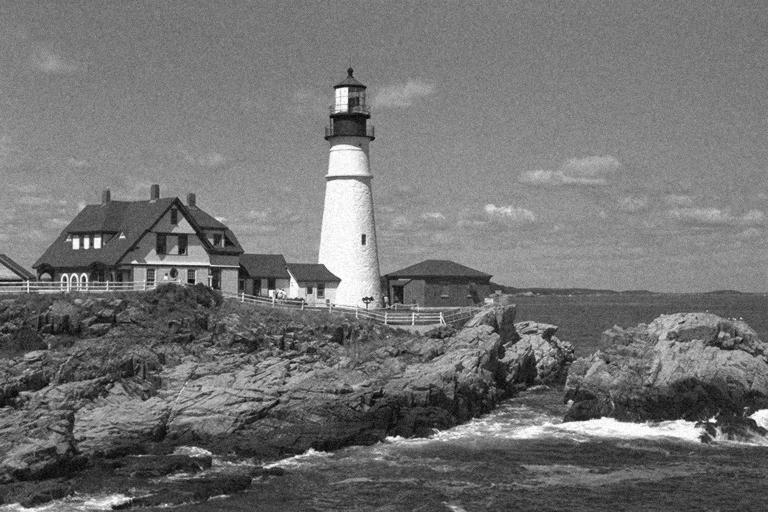

In [ ]:
best_filtered_image = mmse_estimate(noisy_image, 8, 3)
cv2_imshow(best_filtered_image)

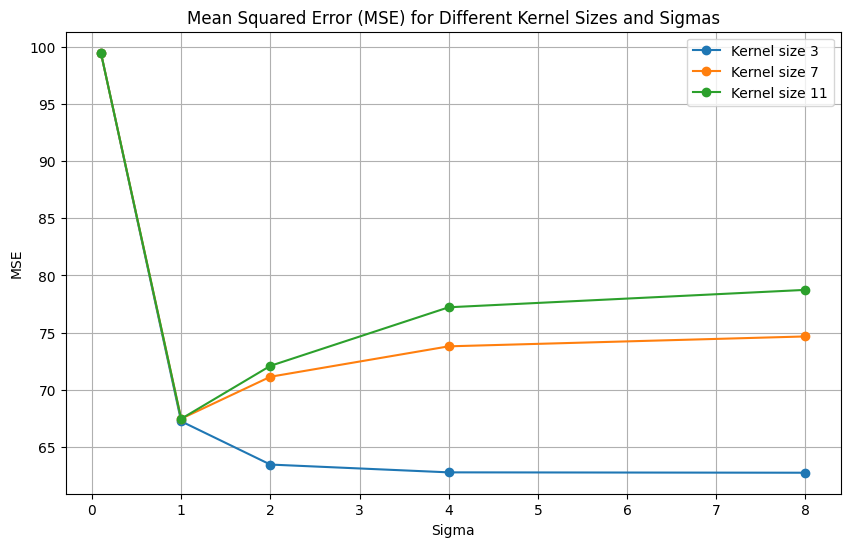

In [ ]:
plt.figure(figsize=(10, 6))
for i, kernel_size in enumerate(kernels):
    plt.plot(sigmas, mse_values[i], label=f'Kernel size {kernel_size}',marker='o')

plt.title('Mean Squared Error (MSE) for Different Kernel Sizes and Sigmas')
plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
kernels = [3, 7, 11]
sigmas = [0.1, 1, 2, 4, 8]


best_kernel_size, best_sigma, best_mse, best_filtered_image, mse_values  = find_best_filter_adaptive(image, noisy_image, kernels, sigmas)


print("Best kernel size:", best_kernel_size)
print("Best sigma:", best_sigma)
print("Best MSE:", best_mse)

Best kernel size: 7
Best sigma: 2
Best MSE: 45.712173


Best Denoised Image

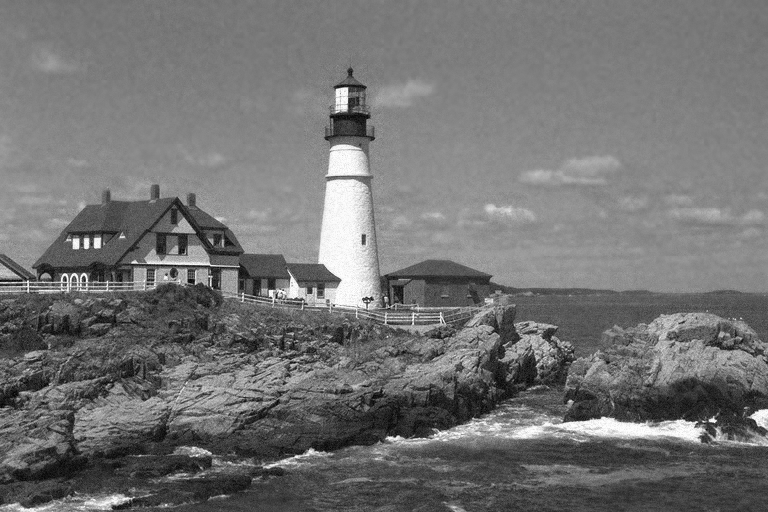

In [ ]:
best_filtered_image = adaptive_mmse_denoising(noisy_image, 2, 7, patch_size=(32, 32), overlap=16, sigma_z=SIGMA_Z)
cv2_imshow(best_filtered_image)

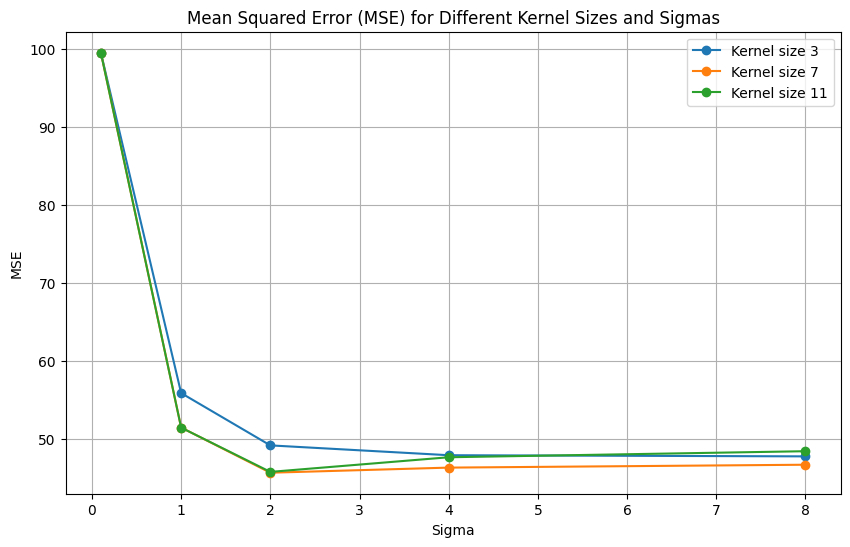

In [ ]:
plt.figure(figsize=(10, 6))
for i, kernel_size in enumerate(kernels):
    plt.plot(sigmas, mse_values[i], label=f'Kernel size {kernel_size}',marker='o')

plt.title('Mean Squared Error (MSE) for Different Kernel Sizes and Sigmas')
plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## 2.3 Adaptive Shrinkage

### Preprocessing

In [ ]:
SIGMA_Z = 10

In [ ]:
image  = cv2.imread('/content/lighthouse2.bmp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
def add_gaussian_noise(image, mean=0, sigma=10):
    row, col = image.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

In [ ]:
noisy_image = add_gaussian_noise(image)

### SUREShrink

Step1: Discrete Wavelet Transform

In [ ]:
def dwt_image(image, wavelet='haar'):
    image = np.float32(image)
    image /= 255.0
    coeffs = pywt.dwt2(image, wavelet)
    return coeffs


def inverse_dwt_image(LL, HL, LH, HH, wavelet = 'haar'):
    reconstructed_image = pywt.idwt2((LL, (HL, LH, HH)), wavelet)
    return reconstructed_image

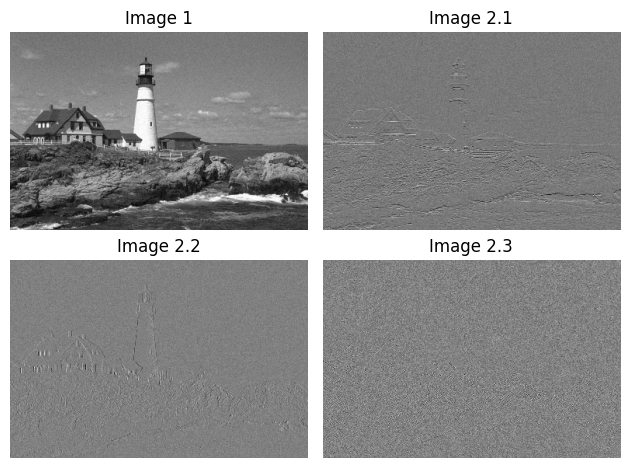

In [ ]:
coeffs = pywt.dwt2(noisy_image, 'haar')

image1 = coeffs[0]
image2_tuple = coeffs[1]
image2_1, image2_2, image2_3 = image2_tuple

plt.subplot(2, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(image2_1, cmap='gray')
plt.title('Image 2.1')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(image2_2, cmap='gray')
plt.title('Image 2.2')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(image2_3, cmap='gray')
plt.title('Image 2.3')
plt.axis('off')

plt.tight_layout()
plt.show()

Step2: Thresholding of Wavelet coefficients

In [ ]:
def shrink(coeffs, threshold):
    coeffs_shrink = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return coeffs_shrink

def reconstruct(coeff, shrink_coeffs):
  denoised_image = pywt.idwt2((coeff, shrink_coeffs), 'haar')
  return denoised_image

Step 3: Stein's unbiased estimate of risk for threshold choice

In [ ]:
def SURE(x, t):
    M = x.shape[0]
    N = x.shape[1]
    A = M * N
    B = 0
    for i in range(M):
        for j in range(N):
            temp = abs(x[i][j])
            temp2 = max(-1*temp, -1*t)
            B += (temp2 ** 2)

    C = 0
    for i in range(M):
        for j in range(N):
            if x[i][j] < t:
                C += 1
    result = (A + B - C) / (M * N)
    return result

Main Function

In [ ]:
def optimal_threshold_shrinkage(original_image,noisy_image):
  thresholds =  np.linspace(1, 50 , 49)
  ts = None ; min = float('inf')

  for threshold in thresholds:
      coeffs = pywt.dwt2(noisy_image, 'haar')
      coeffs_shrink = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1]]
      denoised_image = pywt.idwt2((coeffs[0], coeffs_shrink), 'haar')
      mse = np.mean((original_image-denoised_image)**2)
      if mse < min:
        min = mse
        ts = threshold

  coeffs = pywt.dwt2(noisy_image, 'haar')
  coeffs_shrink = [pywt.threshold(c, ts, mode='soft') for c in coeffs[1]]
  denoised_image = pywt.idwt2((coeffs[0], coeffs_shrink), 'haar')
  return ts, denoised_image

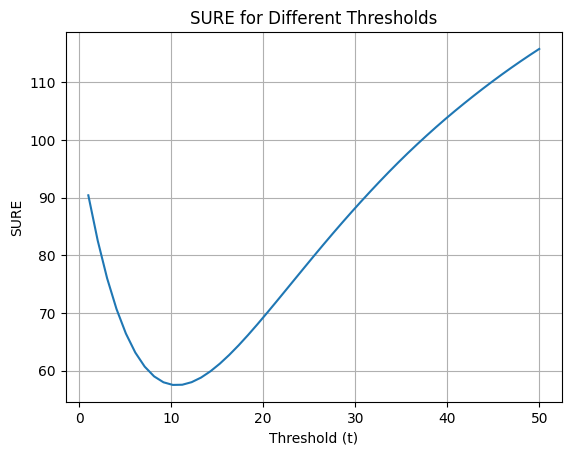

In [ ]:
thresholds =  np.linspace(1, 50 , 49)
mse_arr = []

for threshold in thresholds:
  coeffs = pywt.dwt2(noisy_image, 'haar')
  coeffs_shrink = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1]]
  denoised_image = pywt.idwt2((coeffs[0], coeffs_shrink), 'haar')
  mse = np.mean((image-denoised_image)**2)
  mse_arr.append(mse)

plt.plot(thresholds, mse_arr)
plt.xlabel('Threshold (t)')
plt.ylabel('SURE')
plt.title('SURE values for Different Thresholds')
plt.grid(True)
plt.show()

### Adaptive Shrinkage

In [ ]:
def adaptive_shrinkage(original_image, noisy_image, patch_size=(32, 32), overlap=16):

    height, width = noisy_image.shape
    denoised_image = np.zeros_like(noisy_image, dtype=np.float32)
    count_image = np.zeros_like(noisy_image, dtype=np.float32)

    for y in range(0, height - patch_size[0] + 1, patch_size[0] - overlap):
        for x in range(0, width - patch_size[1] + 1, patch_size[1] - overlap):

            noisy_patch = noisy_image[y:y+patch_size[0], x:x+patch_size[1]]
            original_patch = original_image[y:y+patch_size[0], x:x+patch_size[1]]

            _,denoised_patch = optimal_threshold_shrinkage(original_patch, noisy_patch)
            denoised_image[y:y+patch_size[0], x:x+patch_size[1]] += denoised_patch

            for j in range(y,y+patch_size[0]):
                for i in range(x,x+patch_size[1]):
                  count_image[j,i] += 1

    denoised_image /= count_image
    return denoised_image

In [ ]:
a = adaptive_shrinkage(image, noisy_image)

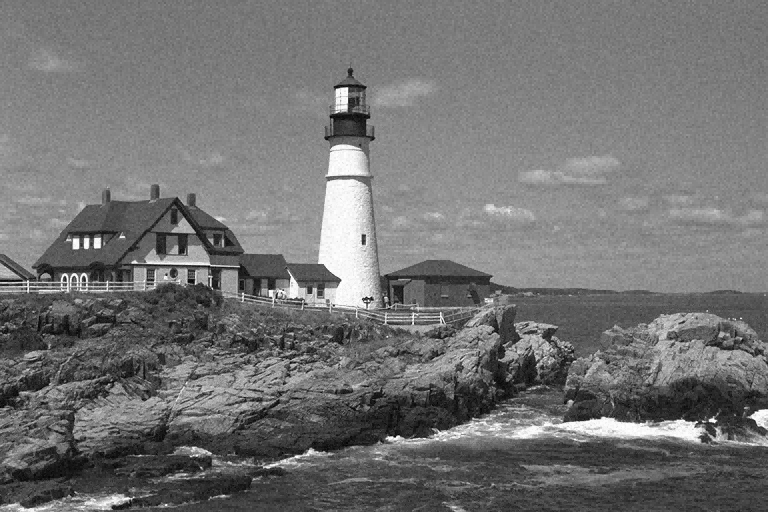

In [ ]:
cv2_imshow(a)

In [ ]:
mse = np.mean((a-image)**2)
mse

50.75891